### Question 3 b) Use GRU with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid function. 

In [2]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

2024-05-06 01:19:22.322689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 01:19:22.347430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 01:19:23.012980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)



In [4]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST TO CONSIDER

/tmp/ipykernel_959/943477194.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_959/943477194.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_959/943477194.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_959/943477194.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Epoch 1/85, Loss: 0.6929, Validation Loss: 0.6916, Train Accuracy: 0.5108, Validation Accuracy: 0.5897
Epoch 2/85, Loss: 0.6897, Validation Loss: 0.6859, Train Accuracy: 0.5404, Validation Accuracy: 0.5827
Epoch 3/85, Loss: 0.6809, Validation Loss: 0.6654, Train Accuracy: 0.5794, Validation Accuracy: 0.6605
Epoch 4/85, Loss: 0.6535, Validation Loss: 0.6250, Train Accuracy: 0.6362, Validation Accuracy: 0.7025
Epoch 5/85, Loss: 0.5906, Validation Loss: 0.5394, Train Accuracy: 0.7039, Validation Accuracy: 0.7390
Epoch 6/85, Loss: 0.5218, Validation Loss: 0.4863, Train Accuracy: 0.7474, Validation Accuracy: 0.7685
Epoch 7/85, Loss: 0.4843, Validation Loss: 0.4561, Train Accuracy: 0.7718, Validation Accuracy: 0.7923
Epoch 8/85, Loss: 0.4579, Validation Loss: 0.4336, Train Accuracy: 0.7858, Validation Accuracy: 0.8025
Epoch 9/85, Loss: 0.4357, Validation Loss: 0.4167, Train Accuracy: 0.7990, Validation Accuracy: 0.8075
Epoch 10/85, Loss: 0.4209, Validation Loss: 0.4007, Train Accuracy: 0.807

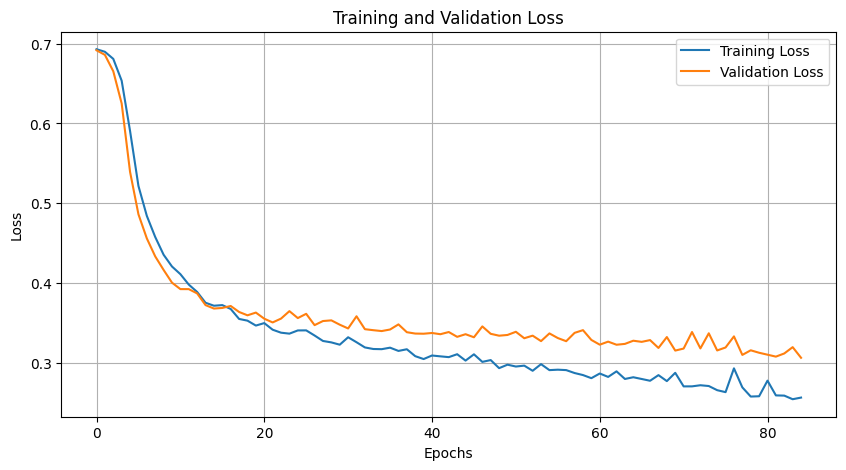

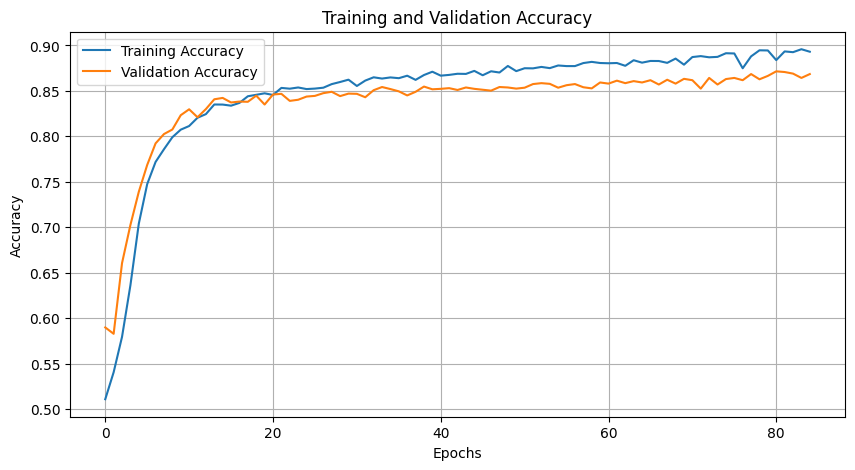

In [23]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out.transpose(1, 2)  # Prepare for max pooling
        pooled_out = self.pool(gru_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.35
batch_size = 700
num_epochs = 85
learning_rate = 0.0004
weight_decay = 9e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Training Loss: 0.2569, Validation Loss: 0.3067
#### Train Accuracy: 0.8931, Validation Accuracy: 0.8685
#### Compute Time: 62 seconds


# PREVIOUS ATTEMPTS

Epoch 1/85, Loss: 0.6949, Validation Loss: 0.6923, Train Accuracy: 0.5009, Validation Accuracy: 0.5135
Epoch 2/85, Loss: 0.6929, Validation Loss: 0.6913, Train Accuracy: 0.5159, Validation Accuracy: 0.5533
Epoch 3/85, Loss: 0.6926, Validation Loss: 0.6903, Train Accuracy: 0.5144, Validation Accuracy: 0.5827
Epoch 4/85, Loss: 0.6910, Validation Loss: 0.6890, Train Accuracy: 0.5259, Validation Accuracy: 0.6118
Epoch 5/85, Loss: 0.6892, Validation Loss: 0.6868, Train Accuracy: 0.5407, Validation Accuracy: 0.6515
Epoch 6/85, Loss: 0.6866, Validation Loss: 0.6832, Train Accuracy: 0.5536, Validation Accuracy: 0.6927
Epoch 7/85, Loss: 0.6812, Validation Loss: 0.6751, Train Accuracy: 0.5744, Validation Accuracy: 0.6933
Epoch 8/85, Loss: 0.6742, Validation Loss: 0.6592, Train Accuracy: 0.5938, Validation Accuracy: 0.7200
Epoch 9/85, Loss: 0.6575, Validation Loss: 0.6339, Train Accuracy: 0.6354, Validation Accuracy: 0.7278
Epoch 10/85, Loss: 0.6239, Validation Loss: 0.5915, Train Accuracy: 0.686

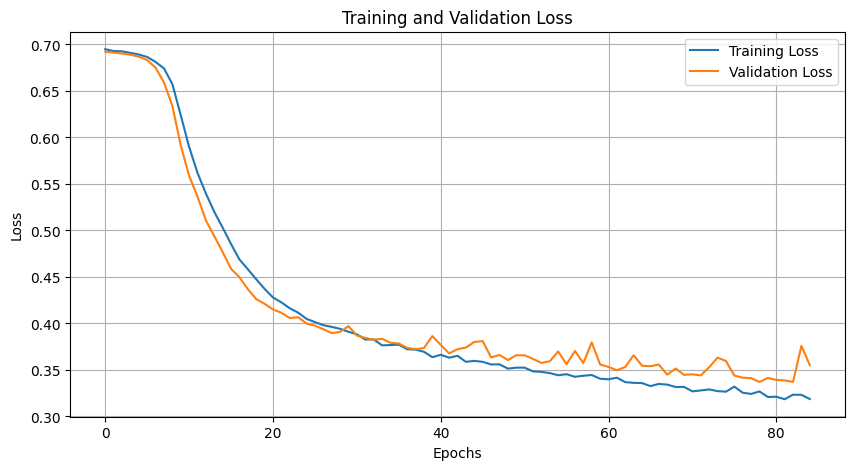

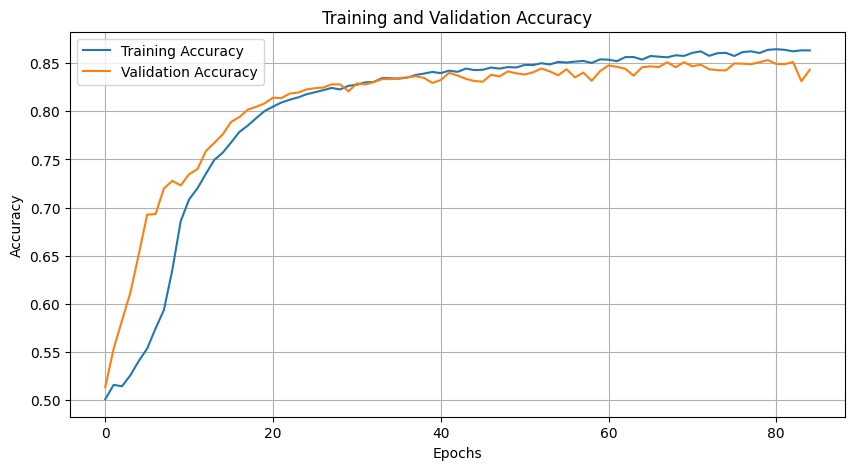

In [4]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out.transpose(1, 2)  # Prepare for max pooling
        pooled_out = self.pool(gru_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 256
num_epochs = 85
learning_rate = 0.00009
weight_decay = 9e-4

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_6090/261379813.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_6090/261379813.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_6090/261379813.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_6090/261379813.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/85, Loss: 0.6976, Validation Loss: 0.6929, Train Accuracy: 0.5031, Validation Accuracy: 0.5028
Epoch 2/85, Loss: 0.6934, Validation Loss: 0.6924, Train Accuracy: 0.5114, Validation Accuracy: 0.5373
Epoch 3/85, Loss: 0.6933, Validation Loss: 0.6919, Train Accuracy: 0.5058, Validation Accuracy: 0.5565
Epoch 4/85, Loss: 0.6921, Validation Loss: 0.6911, Train Accuracy: 0.5189, Validation Accuracy: 0.5380
Epoch 5/85, Loss: 0.6912, Validation Loss: 0.6898, Train Accuracy: 0.5260, Validation Accuracy: 0.5630
Epoch 6/85, Loss: 0.6908, Validation Loss: 0.6884, Train Accuracy: 0.5298, Validation Accuracy: 0.6018
Epoch 7/85, Loss: 0.6893, Validation Loss: 0.6864, Train Accuracy: 0.5386, Validation Accuracy: 0.6180
Epoch 8/85, Loss: 0.6871, Validation Loss: 0.6826, Train Accuracy: 0.5542, Validation Accuracy: 0.6775
Epoch 9/85, Loss: 0.6843, Validation Loss: 0.6784, Train Accuracy: 0.5654, Validation Accuracy: 0.6703
Epoch 10/85, Loss: 0.6788, Validation Loss: 0.6712, Train Accuracy: 0.586

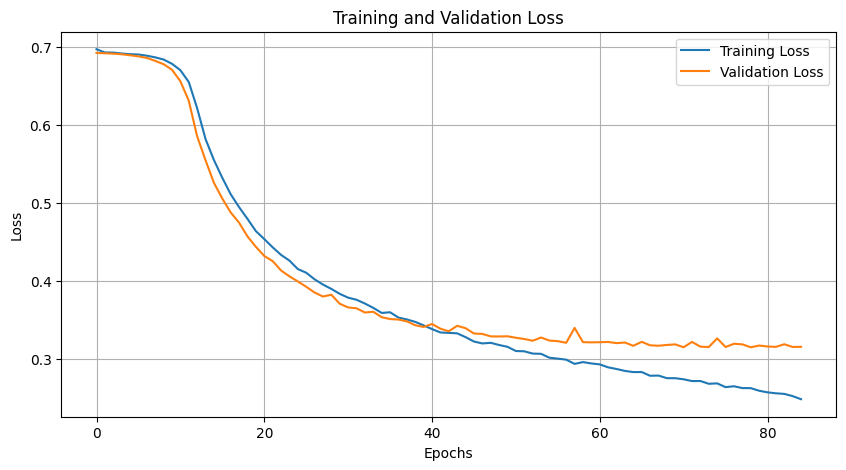

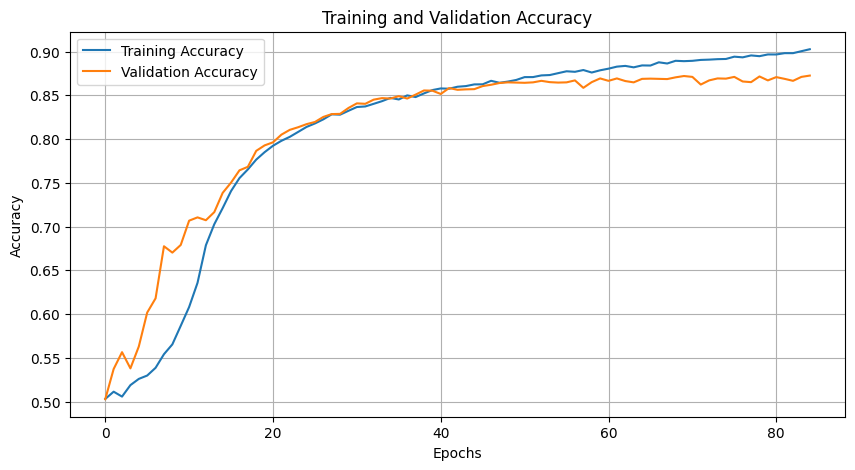

In [7]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out.transpose(1, 2)  # Prepare for max pooling
        pooled_out = self.pool(gru_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 256
num_epochs = 85
learning_rate = 0.00007
weight_decay = 7e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_6090/2192891187.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.long).to(device)
/tmp/ipykernel_6090/2192891187.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
/tmp/ipykernel_6090/2192891187.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.long).to(device)
/tmp/ipykernel_6090/2192891187.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/85, Loss: 0.7067, Validation Loss: 0.6938, Train Accuracy: 0.5036, Validation Accuracy: 0.5000
Epoch 2/85, Loss: 0.6962, Validation Loss: 0.6909, Train Accuracy: 0.5058, Validation Accuracy: 0.5385
Epoch 3/85, Loss: 0.6943, Validation Loss: 0.6895, Train Accuracy: 0.5146, Validation Accuracy: 0.5590
Epoch 4/85, Loss: 0.6933, Validation Loss: 0.6881, Train Accuracy: 0.5180, Validation Accuracy: 0.5865
Epoch 5/85, Loss: 0.6912, Validation Loss: 0.6868, Train Accuracy: 0.5218, Validation Accuracy: 0.6068
Epoch 6/85, Loss: 0.6903, Validation Loss: 0.6853, Train Accuracy: 0.5304, Validation Accuracy: 0.6400
Epoch 7/85, Loss: 0.6893, Validation Loss: 0.6837, Train Accuracy: 0.5351, Validation Accuracy: 0.6595
Epoch 8/85, Loss: 0.6862, Validation Loss: 0.6815, Train Accuracy: 0.5495, Validation Accuracy: 0.6775
Epoch 9/85, Loss: 0.6848, Validation Loss: 0.6781, Train Accuracy: 0.5540, Validation Accuracy: 0.6837
Epoch 10/85, Loss: 0.6804, Validation Loss: 0.6726, Train Accuracy: 0.571

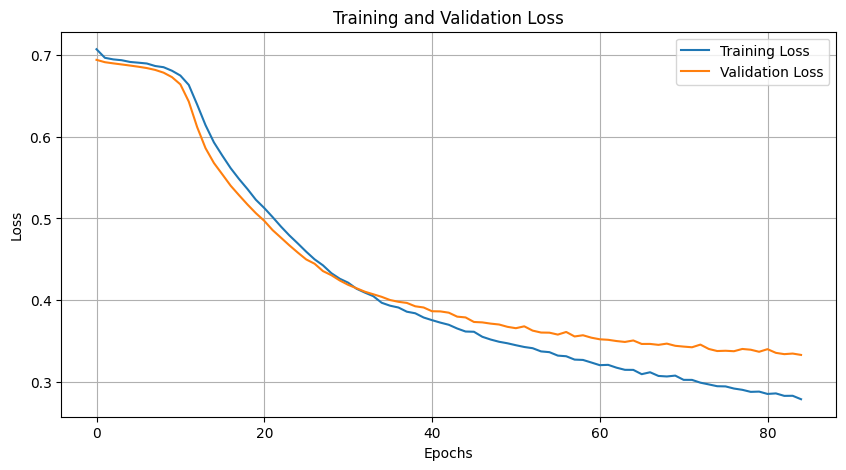

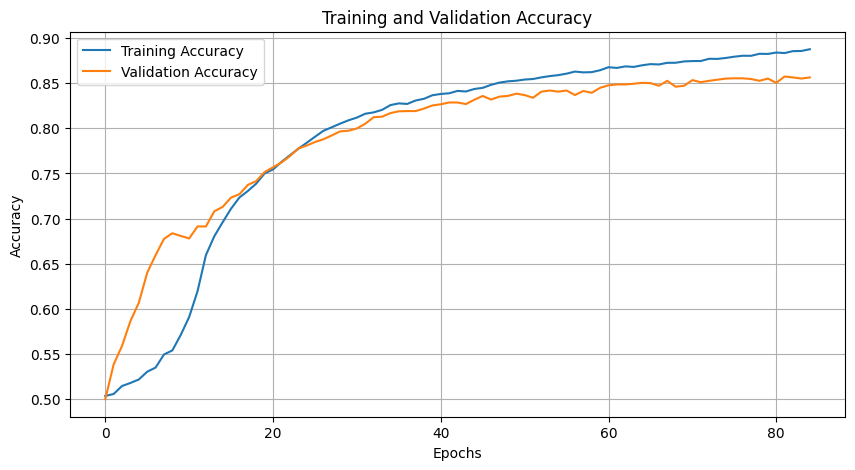

In [8]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out.transpose(1, 2)  # Prepare for max pooling
        pooled_out = self.pool(gru_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 256
num_epochs = 85
learning_rate = 0.00005
weight_decay = 5e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.7008, Validation Loss: 0.6937, Train Accuracy: 0.4999, Validation Accuracy: 0.5002
Epoch 2/85, Loss: 0.6952, Validation Loss: 0.6927, Train Accuracy: 0.5029, Validation Accuracy: 0.5145
Epoch 3/85, Loss: 0.6945, Validation Loss: 0.6922, Train Accuracy: 0.5067, Validation Accuracy: 0.5400
Epoch 4/85, Loss: 0.6932, Validation Loss: 0.6916, Train Accuracy: 0.5126, Validation Accuracy: 0.5545
Epoch 5/85, Loss: 0.6929, Validation Loss: 0.6910, Train Accuracy: 0.5125, Validation Accuracy: 0.5747
Epoch 6/85, Loss: 0.6922, Validation Loss: 0.6904, Train Accuracy: 0.5199, Validation Accuracy: 0.5940
Epoch 7/85, Loss: 0.6918, Validation Loss: 0.6896, Train Accuracy: 0.5186, Validation Accuracy: 0.6100
Epoch 8/85, Loss: 0.6907, Validation Loss: 0.6887, Train Accuracy: 0.5260, Validation Accuracy: 0.6292
Epoch 9/85, Loss: 0.6897, Validation Loss: 0.6876, Train Accuracy: 0.5324, Validation Accuracy: 0.6360
Epoch 10/85, Loss: 0.6890, Validation Loss: 0.6864, Train Accuracy: 0.538

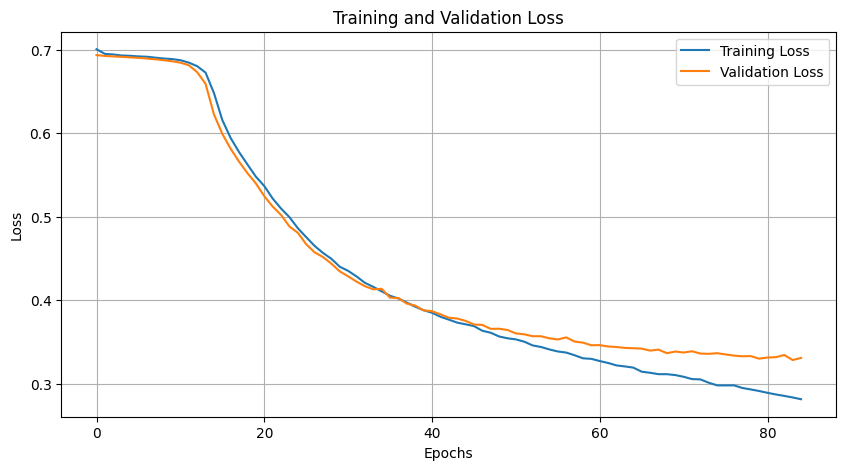

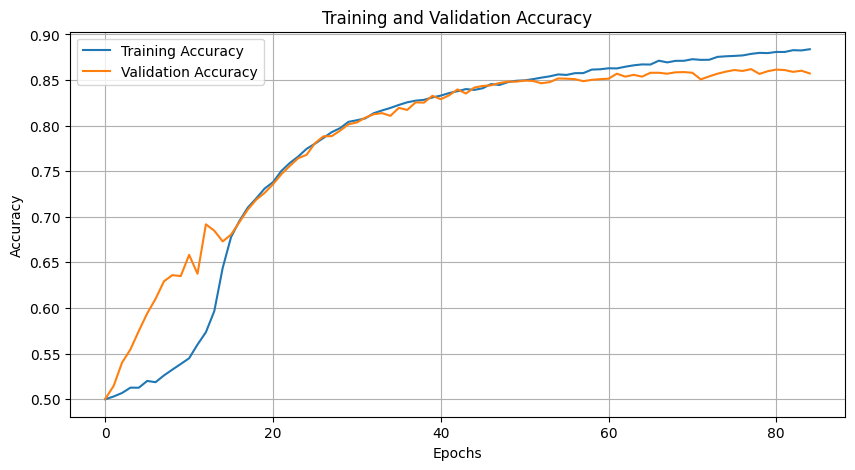

In [5]:
# Convert data to PyTorch tensors and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out.transpose(1, 2)  # Prepare for max pooling
        pooled_out = self.pool(gru_out).squeeze(-1)
        dropped_out = self.dropout(pooled_out)
        fc1_out = self.fc1(dropped_out)
        relu_out = self.relu(fc1_out)
        output = self.fc2(relu_out)
        return self.sigmoid(output)

# Set hyperparameters
input_dim = 10000  # Assuming 'frequentWord' is replaced by actual vocabulary size
embedding_dim = 64
hidden_dim = 64
output_dim = 1  # Assuming binary classification
dropout = 0.5
batch_size = 256
num_epochs = 85
learning_rate = 0.00005
weight_decay = 5e-5

# Instantiate the model and move to device
model = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim, dropout).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            val_loss += loss.item() * inputs.size(0)
            
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
    epoch_val_loss = val_loss / len(val_dataset)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()